In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

from skimage import data, util
from skimage.measure import label, regionprops
from sklearn.model_selection import train_test_split

from gmm_seg_classifier import GaussianModel, GaussianMixtureModel
from roipoly import RoiPoly

train_path = 'data/img/train'
mask_path = 'data/mask/train'

In [2]:
# make some utils
def read_img_to_array(fp):
    # read image file into 8-bit encoded image
    img = cv2.imread(fp)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = util.img_as_ubyte(img)
    return img

def read_mask_to_array(fp):
    # read image file into binary mask
    img = cv2.imread(fp)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = util.img_as_ubyte(img)
    _, binary_mask = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY)
    return binary_mask > 0

In [22]:
# import image
filenames = os.listdir(train_path)
train_files, test_files = train_test_split(filenames, test_size=0.2)
print(len(train_files), len(test_files))

20 5


In [23]:
# train
X_cone = []
X_bg = []
for filename in train_files:
    # assemble into set of pixels X
    if filename.endswith(('.png', '.jpg')):
        img = read_img_to_array(os.path.join(train_path,filename))
        mask = read_mask_to_array(os.path.join(mask_path, filename))
        cone = img[mask]
        background = img[np.invert(mask)]

        X_cone.append(cone)
        X_bg.append(background)
X_cone = np.concatenate(X_cone)
X_bg = np.concatenate(X_bg)

n_cone_pixel = X_cone.shape[0]
n_bg_pixel = X_bg.shape[0]
p_cone = n_cone_pixel / (n_cone_pixel + n_bg_pixel)

cone_gaussian_model = GaussianModel()
bg_gaussian_model = GaussianModel()

cone_gaussian_model.fit(X_cone)
bg_gaussian_model.fit(X_bg)

In [61]:
# image processing
def classify_image_pixels(image):
    W, H, _ = image.shape
    mask = np.zeros((W,H))
    for x in range(W):
        for y in range(H):
            pixel = image[x,y,:]
            p_x_cone = cone_gaussian_model.predict(pixel)
            p_x_bg = bg_gaussian_model.predict(pixel)
            p_x = ((p_x_cone * p_cone) + p_x_bg * (1 - p_cone))
            p_cone_x = (p_x_cone * p_cone) / p_x
            mask[x,y] = p_cone_x[0]

    return mask 


def draw_triangle_around_positive_pixels(image, thresh):
    mask = classify_image_pixels(image)

    #dilation and erosion to clean up
    kernel = np.ones((3, 3), np.uint8)
    mask_cleaned = mask
    mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_OPEN, kernel, iterations=2)
    mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)
    binary_mask = mask_cleaned > thresh

    contours, _ = cv2.findContours(binary_mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        # approximate the contour to reduce the number of points
        epsilon = 0.01 * cv2.arcLength(cnt, True)
        cnt = cv2.approxPolyDP(cnt, epsilon, True)

        x, y, w, h = cv2.boundingRect(cnt)
        triangle = np.array([
            [x + w // 2, y], # top
            [x, y + h], # right
            [x + w, y + h] # left
        ])
        cv2.drawContours(image, [triangle], 0, (0, 255, 0), 2)  # Green, tickness 2
    
    return image, triangle


In [62]:
# geometry processing
def centroid_triangle(t):
    return np.mean(t, axis=0)

def triangle_geometry(triangle):
    centroid = np.mean(triangle, axis=0).squeeze().astype(int)
    x = centroid[0]
    y = centroid[1]

    f = 50 # hand-calculated focal length
    h = np.abs(triangle[0][1] - triangle[1][1])
    w = np.abs(triangle[1][0] - triangle[2][0])
    d_1 = f * 17 / h
    d_2 = f * 7.5 / w
    d = (d_1 + d_2) / 2

    return x, y, d

/var/folders/_n/s_1tc7593sjfwlhsrvn7vxkh0000gn/T/ipykernel_21894/724779322.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mask[x,y] = p_cone_x[0]
/var/folders/_n/s_1tc7593sjfwlhsrvn7vxkh0000gn/T/ipykernel_21894/724779322.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mask[x,y] = p_cone_x[0]
/var/folders/_n/s_1tc7593sjfwlhsrvn7vxkh0000gn/T/ipykernel_21894/724779322.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mask[x,y] = p_cone_x[0]
/var/folders/

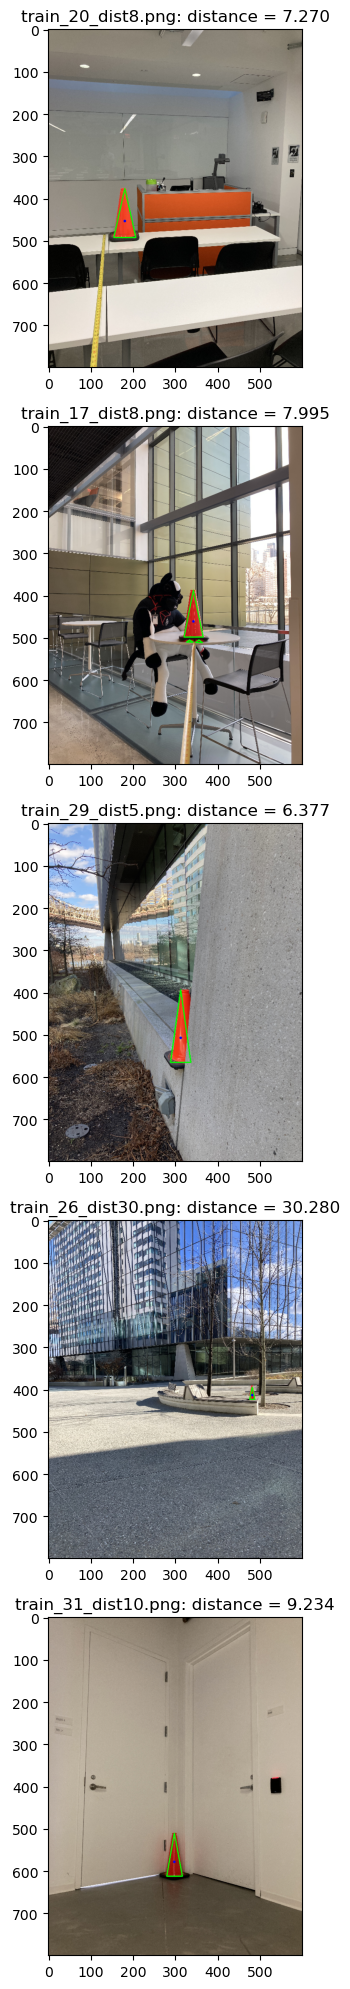

In [65]:
# test
n_subplots = len(test_files)
fig, axs = plt.subplots(n_subplots, 1, figsize=(20, 20))

triangles = []
thresh = 0.99

for i, filename in enumerate(test_files):
    # assemble into set of pixels X
    if filename.endswith(('.png', '.jpg')):
        img = read_img_to_array(os.path.join(train_path,filename))
        img_overlay, t = draw_triangle_around_positive_pixels(img, thresh)
        
        triangles.append(t)
        x, y, d = triangle_geometry(t)

        cv2.circle(img_overlay, (x,y), radius=3, color=(0, 0, 255), thickness=-1)
        axs[i].imshow(img_overlay)
        axs[i].set_title(f'{filename}: distance = {d:.3f}')

plt.tight_layout()
plt.show()